In [118]:
import warnings
warnings.filterwarnings('ignore')

https://arxiv.org/pdf/2308.04419.pdf

In [119]:
import yfinance as yf
import pandas as pd
import numpy as np

In [120]:
input_length = 10
target_length = 1

In [121]:
# AAPL hisse senedi sembolü
symbol = "AAPL"

# Tarih aralığını belirleyin (örneğin, son 1 yıl)
start_date = "2022-01-01"
end_date = "2023-01-01"

period = "5y"
interval = "1d"

# Verileri çek
# data = yf.download(symbol, start=start_date, end=end_date)
data = yf.download(symbol, period=period, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [122]:
# Veriyi göster
print(data.head())

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-22  39.102501  39.182499  38.154999  38.325001  36.784752  121576000
2019-01-23  38.537498  38.785000  37.924999  38.480000  36.933525   92522400
2019-01-24  38.527500  38.619999  37.935001  38.174999  36.640781  101766000
2019-01-25  38.869999  39.532501  38.580002  39.439999  37.854950  134142000
2019-01-28  38.947498  39.082500  38.415001  39.075001  37.504608  104768400


In [123]:
data['Target'] = data['Close'].shift(-target_length)
data.drop('Adj Close', axis=1, inplace=True)
data = data.dropna()
print(data.head(5))

                 Open       High        Low      Close     Volume     Target
Date                                                                        
2019-01-22  39.102501  39.182499  38.154999  38.325001  121576000  38.480000
2019-01-23  38.537498  38.785000  37.924999  38.480000   92522400  38.174999
2019-01-24  38.527500  38.619999  37.935001  38.174999  101766000  39.439999
2019-01-25  38.869999  39.532501  38.580002  39.439999  134142000  39.075001
2019-01-28  38.947498  39.082500  38.415001  39.075001  104768400  38.669998


In [124]:
def calculate_adx_di(df, len_param=14):
    """
    Verilen bir DataFrame'e ADX ve DIPlus, DIMinus sütunlarını ekleyen fonksiyon.

    Parameters:
    - df: DataFrame, Hissedarlık verilerini içeren DataFrame.
    - len_param: int, SmoothedTrueRange ve ADX hesaplamak için kullanılacak periyot.

    Returns:
    - df: DataFrame, Güncellenmiş DataFrame.
    """

    # TrueRange hesaplama
    df['TrueRange'] = df.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - df['Close'].shift(1)[row.name]), abs(row['Low'] - df['Close'].shift(1)[row.name])), axis=1)

    # Directional Movement hesaplama
    df['DirectionalMovementPlus'] = df.apply(lambda row: max(row['High'] - df['High'].shift(1)[row.name], 0) if row['High'] - df['High'].shift(1)[row.name] > df['Low'].shift(1)[row.name] - row['Low'] else 0, axis=1)
    df['DirectionalMovementMinus'] = df.apply(lambda row: max(df['Low'].shift(1)[row.name] - row['Low'], 0) if df['Low'].shift(1)[row.name] - row['Low'] > row['High'] - df['High'].shift(1)[row.name] else 0, axis=1)

    # # Smoothed TrueRange ve Directional Movement hesaplama
    df['SmoothedTrueRange'] = 0.0
    df['SmoothedDirectionalMovementPlus'] = 0.0
    df['SmoothedDirectionalMovementMinus'] = 0.0

    for i in range(1, len(df)):
        df.at[df.index[i], 'SmoothedTrueRange'] = df.at[df.index[i-1], 'SmoothedTrueRange'] - (df.at[df.index[i-1], 'SmoothedTrueRange'] / len_param) + df.at[df.index[i], 'TrueRange']
        df.at[df.index[i], 'SmoothedDirectionalMovementPlus'] = df.at[df.index[i-1], 'SmoothedDirectionalMovementPlus'] - (df.at[df.index[i-1], 'SmoothedDirectionalMovementPlus'] / len_param) + df.at[df.index[i], 'DirectionalMovementPlus']
        df.at[df.index[i], 'SmoothedDirectionalMovementMinus'] = df.at[df.index[i-1], 'SmoothedDirectionalMovementMinus'] - (df.at[df.index[i-1], 'SmoothedDirectionalMovementMinus'] / len_param) + df.at[df.index[i], 'DirectionalMovementMinus']

    # DIPlus, DIMinus ve ADX hesaplama
    df['DIPlus'] = df['SmoothedDirectionalMovementPlus'] / df['SmoothedTrueRange'] * 100
    df['DIMinus'] = df['SmoothedDirectionalMovementMinus'] / df['SmoothedTrueRange'] * 100
    df['DX'] = abs(df['DIPlus'] - df['DIMinus']) / (df['DIPlus'] + df['DIMinus']) * 100
    df['ADX'] = df['DX'].rolling(window=len_param).mean()

    # Gereksiz sütunları düşürme
    df = df.drop(['TrueRange', 'DirectionalMovementPlus', 'DirectionalMovementMinus', 'SmoothedTrueRange', 'SmoothedDirectionalMovementPlus', 'SmoothedDirectionalMovementMinus', 'DX'], axis=1)

    # İlk 14 satırın NaN değerlerini temizleme
    df = df.dropna()

    return df

data = calculate_adx_di(data)

In [125]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume', 'DIPlus', 'DIMinus', 'ADX']].values
# X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values

In [126]:
data.tail()

cols = data.columns
inds = data.index

In [127]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [128]:
# y = data[['Close']].values

In [129]:
# define the size of the training set
train_size = int(len(data) * 0.8)

train, test = data.iloc[:train_size, :], data.iloc[train_size:, :]

In [130]:
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset.drop(['Target'], axis=1).iloc[i:(i+time_steps), :].values
        X.append(a)
        y.append(dataset.iloc[i, 5])
    return np.array(X), np.array(y).reshape(-1, 1)

In [131]:
X_train, y_train = create_dataset(train, input_length)
X_test, y_test = create_dataset(test, input_length)

In [132]:
# # split the data into training and testing sets
# X_train, X_test = X[:train_size, :], X[train_size:, :]
# y_train, y_test = y[:train_size], y[train_size:]

In [133]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(984, 10, 8)
(984, 1)
(239, 10, 8)
(239, 1)


In [134]:
from sklearn.preprocessing import MinMaxScaler

# # normalize the data using MinMaxScaler
# X_scaler = MinMaxScaler(feature_range=(0, 1))
# y_scaler = MinMaxScaler(feature_range=(0, 1))
# 
# X_train = X_scaler.fit_transform(X_train)
# y_train = y_scaler.fit_transform(y_train)
# 
# X_test = X_scaler.transform(X_test)
# y_test = y_scaler.transform(y_test)

# Eğitim ve test setlerini göster
print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti:", X_test.shape, y_test.shape)

Eğitim seti: (984, 10, 8) (984, 1)
Test seti: (239, 10, 8) (239, 1)


In [135]:
# reshape the input data into 3D format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], input_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], input_length, X_test.shape[2]))

In [136]:
# Eğitim ve test setlerini göster
print("Eğitim seti:", X_train.shape, y_train.shape)
print("Test seti:", X_test.shape, y_test.shape)

Eğitim seti: (984, 10, 8) (984, 1)
Test seti: (239, 10, 8) (239, 1)


In [137]:
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense

# define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [138]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 100)           43600     
                                                                 
 dropout_6 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_7 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [139]:
# train the model
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
callback = EarlyStopping(patience=5)

model_his = model.fit(X_train, y_train, epochs=30, batch_size=1, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint, callback])

Epoch 1/30
984/984 [==============================] - ETA: 0s - loss: 0.0714
Epoch 1: val_loss improved from inf to 0.16949, saving model to best_model.h5
984/984 [==============================] - 15s 11ms/step - loss: 0.0714 - val_loss: 0.1695
Epoch 2/30
978/984 [============================>.] - ETA: 0s - loss: 0.0483
Epoch 2: val_loss improved from 0.16949 to 0.04968, saving model to best_model.h5
984/984 [==============================] - 8s 8ms/step - loss: 0.0483 - val_loss: 0.0497
Epoch 3/30
978/984 [============================>.] - ETA: 0s - loss: 0.0441
Epoch 3: val_loss did not improve from 0.04968
984/984 [==============================] - 8s 8ms/step - loss: 0.0440 - val_loss: 0.0564
Epoch 4/30
983/984 [============================>.] - ETA: 0s - loss: 0.0413
Epoch 4: val_loss improved from 0.04968 to 0.03097, saving model to best_model.h5
984/984 [==============================] - 8s 8ms/step - loss: 0.0413 - val_loss: 0.0310
Epoch 5/30
982/984 [=========================

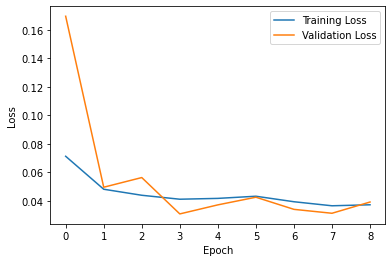

In [140]:
import matplotlib.pyplot as plt

# Plot the training loss
plt.plot(model_his.history['loss'], label='Training Loss')
plt.plot(model_his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [141]:
preds = model.predict(X_test)

In [142]:
# inverse transform eklenecek

In [143]:
# min_values = scaler.data_min_
# max_values = scaler.data_max_
# data_range = scaler.data_range_

In [144]:
import matplotlib.pyplot as plt
import numpy as np

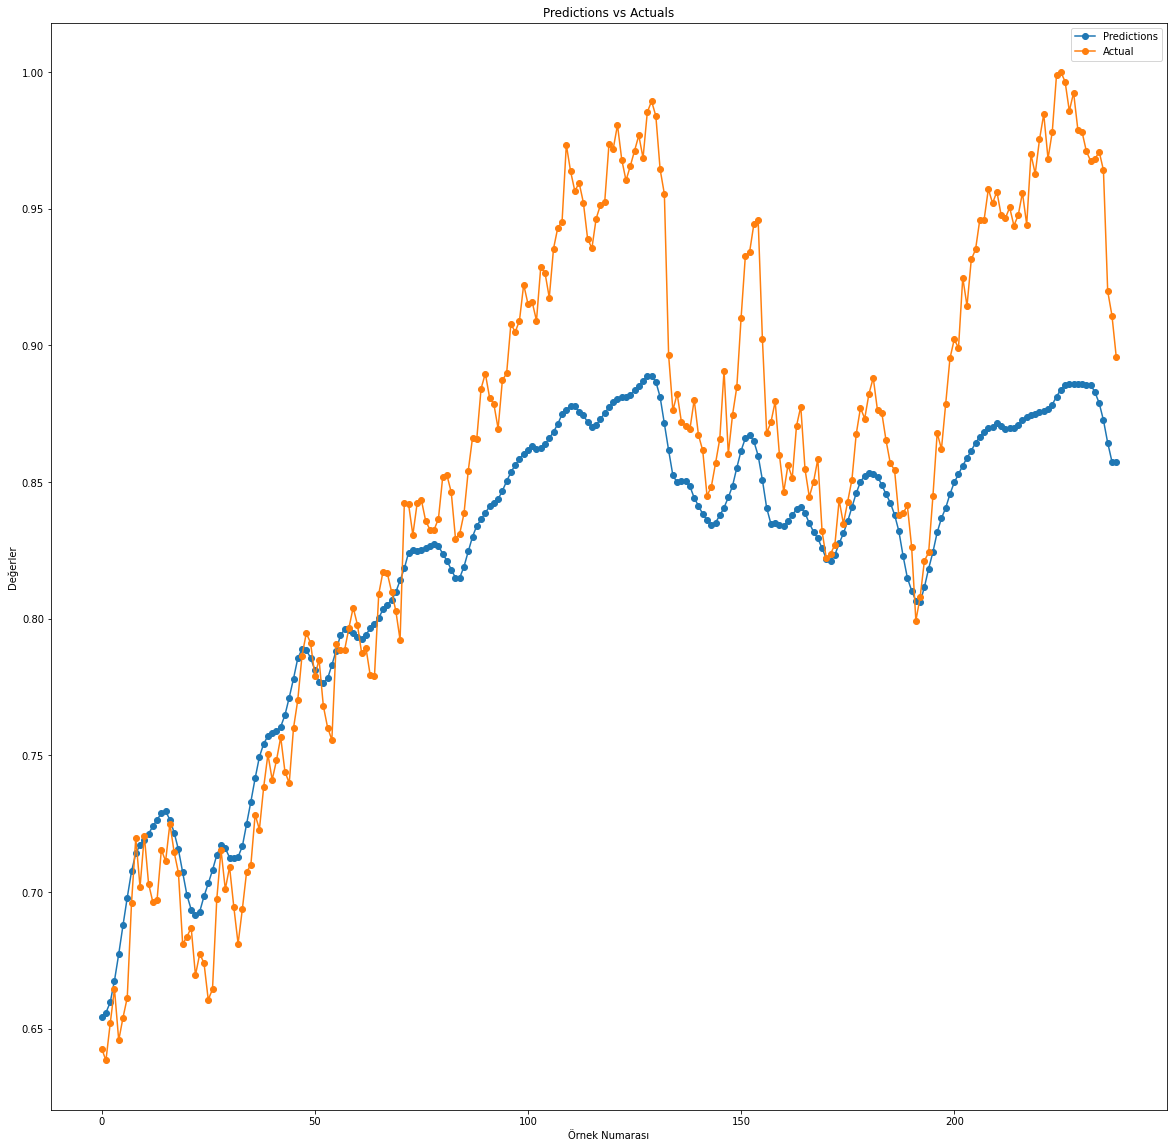

In [145]:
# X eksenindeki değerler
x_values = np.arange(len(preds))


plt.figure(figsize=(20, 20))


# Çizgi grafikleri oluştur
plt.plot(x_values, preds, label='Predictions', marker='o')
plt.plot(x_values, y_test, label='Actual', marker='o')

# Eksen etiketleri
plt.xlabel('Örnek Numarası')
plt.ylabel('Değerler')

# Başlık
plt.title('Predictions vs Actuals')

# İlgili yeri göster
plt.legend()

plt.savefig('example_plot.png')

# Grafik göster
plt.show()

In [146]:
from sklearn.metrics import mean_absolute_error as mae

# calculate MAE 
error = mae(preds, y_test) 
  
# display 
print("Mean absolute error : " + str(error)) 

Mean absolute error : 0.039303990045028984


In [147]:
from sklearn.metrics import mean_absolute_percentage_error

error = mean_absolute_percentage_error(preds, y_test)
print("Mean absolute error : " + str(error)) 

Mean absolute error : 0.046351176298863574


In [148]:
for index, value in enumerate(preds):
    print(value, y_test[index])

[0.65413904] [0.64272169]
[0.6558745] [0.63841482]
[0.6596447] [0.65191404]
[0.6675621] [0.66457746]
[0.67731214] [0.64574294]
[0.6878195] [0.65403525]
[0.69799376] [0.66136337]
[0.7075306] [0.69601136]
[0.7141187] [0.71966702]
[0.7172164] [0.70186093]
[0.7189077] [0.72063121]
[0.7213551] [0.7030823]
[0.7239969] [0.69633269]
[0.72651565] [0.69723263]
[0.72877777] [0.71548874]
[0.7295505] [0.71131037]
[0.7264633] [0.72500242]
[0.7217499] [0.7145888]
[0.7155763] [0.70713209]
[0.7073233] [0.68096934]
[0.69887555] [0.68373351]
[0.69355893] [0.68688326]
[0.69162095] [0.66959153]
[0.69282925] [0.67736958]
[0.69842935] [0.67409124]
[0.7031323] [0.66059202]
[0.7080177] [0.66444897]
[0.71351445] [0.69736122]
[0.7170546] [0.71536015]
[0.716048] [0.70102533]
[0.71262467] [0.70918905]
[0.7122849] [0.69453281]
[0.71285474] [0.68109793]
[0.7167225] [0.69376146]
[0.7248994] [0.70738917]
[0.7330867] [0.7099605]
[0.74161184] [0.7283451]
[0.7494364] [0.72288111]
[0.7542604] [0.73830871]
[0.75708663] [0.